In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import Adam
from torchvision.transforms import transforms, Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST
from torch.utils.data import DataLoader, random_split
from tools.models import *
from tools.data_utils import *
from tools.plot_utils import *
import matplotlib.pyplot as plt
import numpy as np
import random
import imageio
from argparse import ArgumentParser
import einops


# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"./history/ddpm_model_mnist.pt"
STORE_PATH_SYNTH = f"./history/ddpm_model_synth.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train_losses = []
test_losses = []


def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps
    for epoch in range(num_epochs):
        train_loss = 0
        for data in train_dataloader:
            # Loading data
            
            # UNCOMMENT BELOW FOR SYNTH
            x0 = data["image"].float().to(device)
            
            # UNCOMMENT BELOW FOR MNIST
            # x0 = data[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)
            
            print(x0.dtype)
            print(t.dtype)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta, _ = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            train_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {train_loss:.3f}"
    
        # Storing the model
        if best_loss > train_loss:
            best_loss = train_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

            # Evaluation on the test set
#     test_loss = 0.0
#     with torch.no_grad():
#         for data in test_dataloader:
#             inputs, _ = data
#             inputs = inputs.view(inputs.size(0), -1)
        
#             # Forward pass through the autoencoder
#             outputs = autoencoder(inputs)
        
#             # Calculate the test loss
#             loss = criterion(outputs, inputs)
#             test_loss += loss.item()

#     # Calculate average test loss for the epoch
#     test_loss /= len(test_dataloader)
#     test_losses.append(test_loss)

#     print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}')
        

# # Plot the training and test losses
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
# plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.title('Autoencoder Training and Test Losses')
# plt.show()

In [3]:
# Hyperparameters
# dataset = "MNIST"
dataset = "Synthetic"
store_path = f"./history/ddpm_{dataset}.pt"
batch_size = 128
learning_rate = 0.001
num_epochs = 20

# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
if dataset == "MNIST":
    ds_fn = MNIST
    dataset = ds_fn("./datasets", download=True, train=True, transform=transform)

if dataset == "Synthetic":
    data_folder = "./data/Synthetic/10images_28by28pixels_4_distanced_grid_pins_4seed"
    dataset = PinDataset(csv_file=f"{data_folder}/pins.csv",
                                  root_dir=f"{data_folder}/images/",
                                  transform=transforms.Compose([ToTensor(), Resize()])
                        )

train_dataloader = DataLoader(dataset, batch_size, shuffle=True)

# if dataset == "MNIST":
#     # Load the MNIST dataset and split into training and testing sets
#     transform = transforms.Compose([transforms.ToTensor()])
#     mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

#     # Split the dataset into 1000 training and 200 testing
#     # Define the sizes for train, validation, and test sets
#     train_size = 1000
#     val_size = len(mnist_dataset) - train_size - 200  # The rest goes to the validation set
#     test_size = 200

#     # Use random_split to create the datasets
#     train_dataset, val_dataset, test_dataset = random_split(mnist_dataset, [train_size, val_size, test_size])

# # Create data loaders for training and testing
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the autoencoder
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
model = DDPM(UNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
training_loop(model, train_dataloader, num_epochs, optimizer, device, store_path=store_path)

torch.float32
torch.int64
Loss at epoch 1: 1.011 --> Best model ever (stored)
torch.float32
torch.int64
Loss at epoch 2: 1.030
torch.float32
torch.int64
Loss at epoch 3: 1.000 --> Best model ever (stored)
torch.float32
torch.int64
Loss at epoch 4: 1.013
torch.float32
torch.int64
Loss at epoch 5: 0.996 --> Best model ever (stored)
torch.float32
torch.int64
Loss at epoch 6: 1.009
torch.float32
torch.int64
Loss at epoch 7: 1.007
torch.float32
torch.int64
Loss at epoch 8: 1.005
torch.float32
torch.int64
Loss at epoch 9: 1.001
torch.float32
torch.int64
Loss at epoch 10: 0.991 --> Best model ever (stored)
torch.float32
torch.int64
Loss at epoch 11: 0.986 --> Best model ever (stored)
torch.float32
torch.int64
Loss at epoch 12: 1.000
torch.float32
torch.int64
Loss at epoch 13: 0.988
torch.float32
torch.int64
Loss at epoch 14: 0.996
torch.float32
torch.int64
Loss at epoch 15: 0.985 --> Best model ever (stored)
torch.float32
torch.int64
Loss at epoch 16: 0.985 --> Best model ever (stored)
torch.

Model loaded
Generating new images


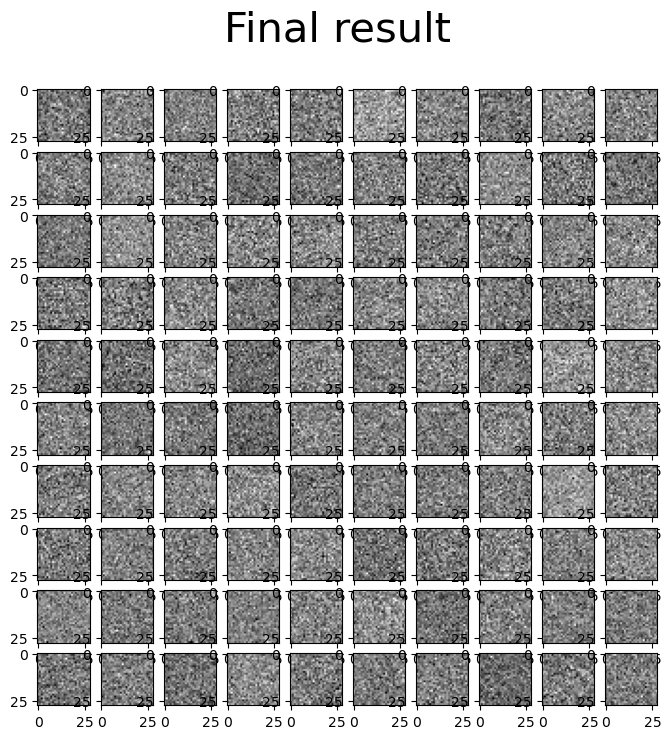

In [4]:
# Loading the trained model
best_model = DDPM(UNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="mnist.gif",
        c=4
    )
show_images(generated, "Final result")

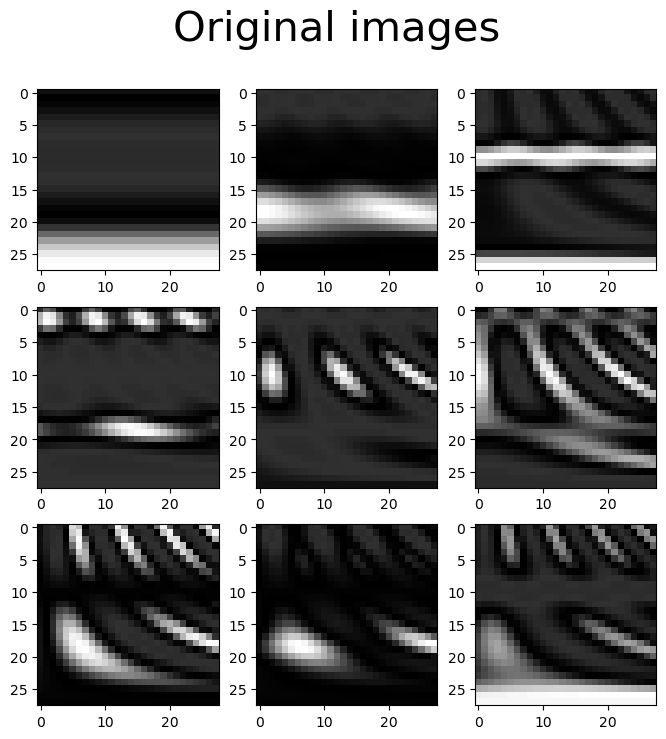

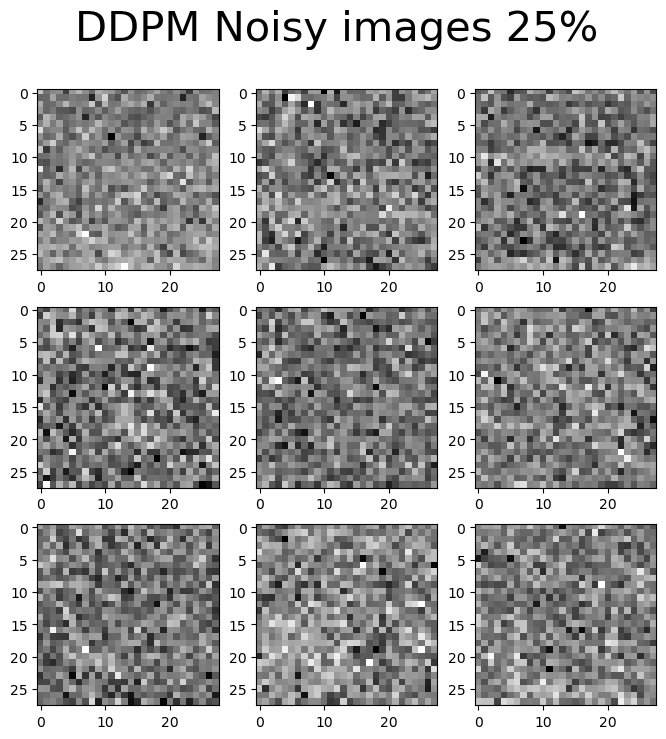

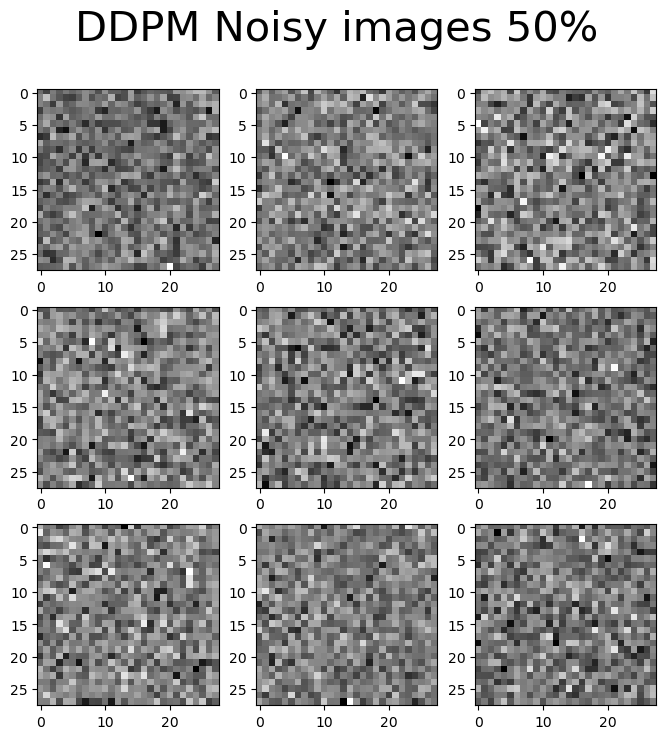

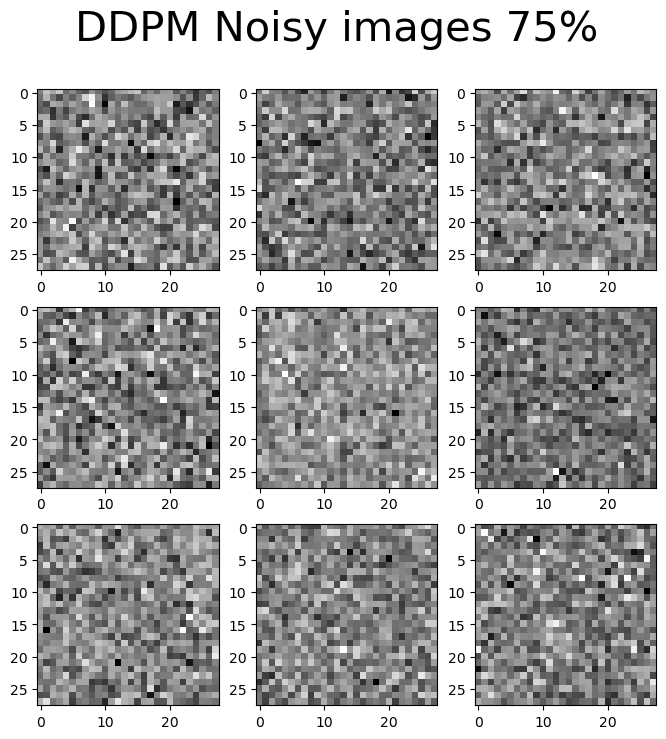

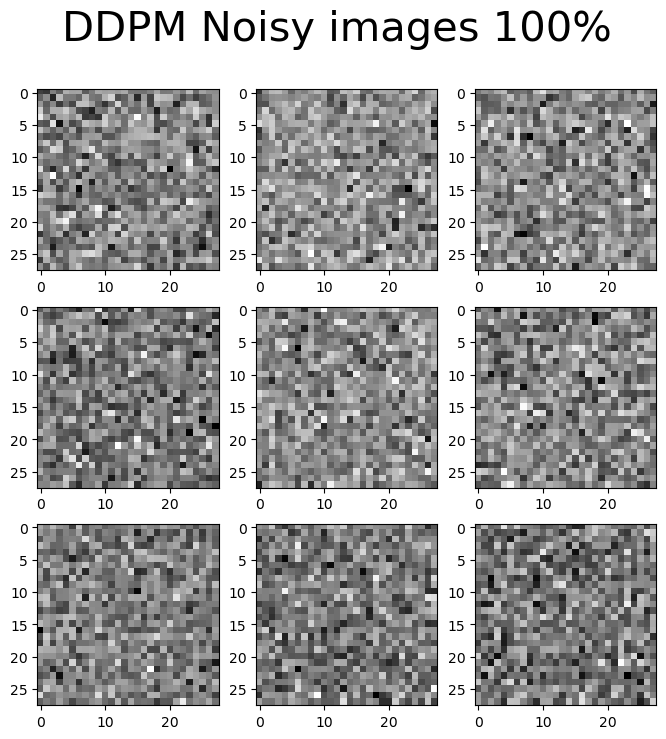

In [6]:
show_forward(model, train_dataloader, device)